# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***
The goal of this project is to write software pipeline to identify the lane boundaries in a video from a front-facing camera. 

The project include three steps:
* Camera calibration: compute the camera matrix and distortion coefficients. 
* Develop a pipeline for lane finding in single images.
* Develop a pipeline for lane finding in video.

## Camera Calibration

Cameras use lenses which can make the light to bend at the edges of the lenses, which cause distortion. This can make the object to appear more or less curved than what actually are (radial distortion) or objects might appear further away or closer than what they actually are (tangential distortion). This should be corrected in order to accurately determine the position and distance of the objects.

So, the first step is to obtain the 5 coefficients (k1, k2, p1, p2 and k3) which reflect the radial and tangential distortion in an image, and that would allow us to undistort the images of the camera.

To calculate the 5 coefficients, I will use pictures of a known shapes (chessboard) and correct for distortion errors.

## Import packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [2]:
# Define a helper function in order to calibrate a camera
# It receives as a parameter the number of inside corner points of the chessboard (nx, ny) and the set of images for calibration
def calibrate_camera(nx, ny, images):
    # store the 3d points in real world space
    objpoints = []

    # store the 2d points in image plane
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    size = 0 # size of the image (width and height in pixel)

    for image in images:
        img = cv2.imread(image)

        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if (size == 0): # we still have not calculated the size
            size = gray.shape[::-1]

        # find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            # Append the img points and obj points
            imgpoints.append(corners)
            objpoints.append(objp)

    # Now that we have the set of image points and corresponding obj points, we can calibrate the camera. The camera
    # calibration returns: ret, mtx (camera matrix to transform 3d object points to 2d image points), dist (distorted coefficients), rvecs and tvecs (rotation and translation vector which position camera in the world)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size, None, None)
    return ret, mtx, dist, rvecs, tvecs


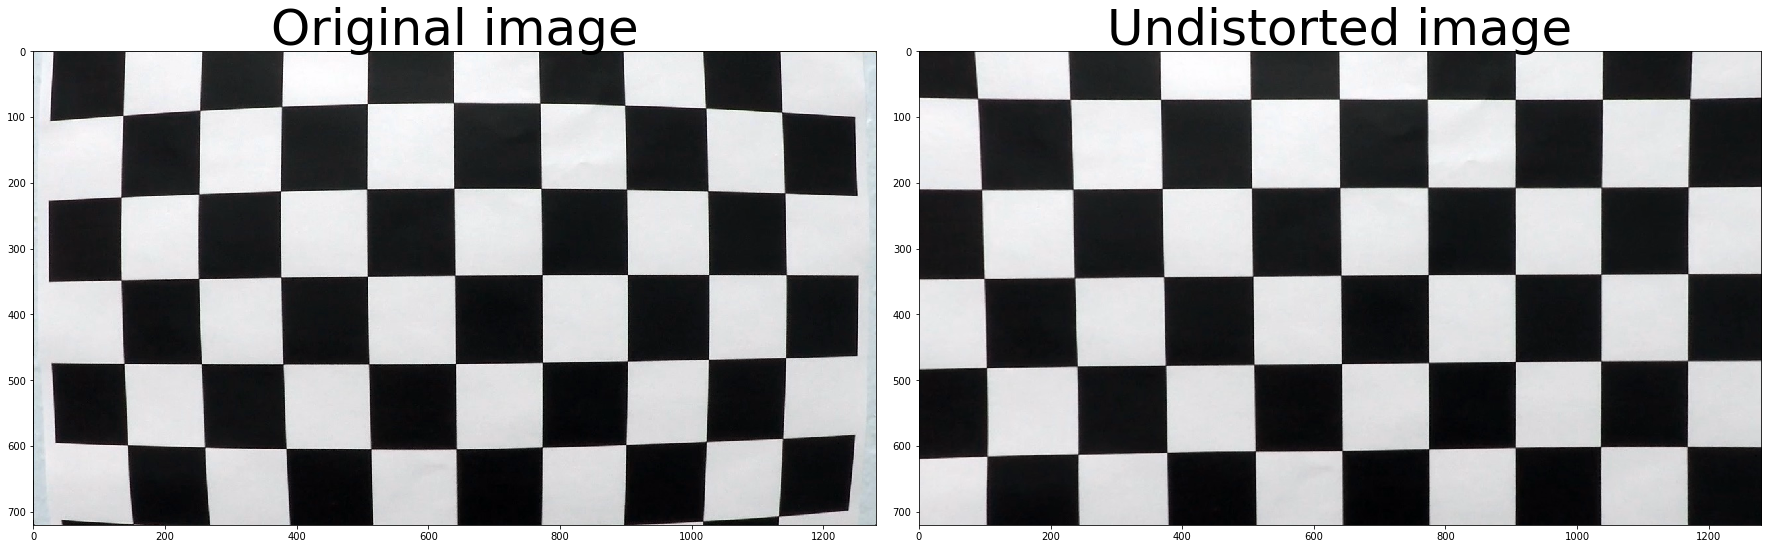

In [3]:
# number of object points (number of inside corners of the chessboard in x and y direction)
nx = 9
ny = 6
ret, mtx, dist, rvecs, tvecs = calibrate_camera(nx, ny, glob.glob("camera_cal/calibration*.jpg"))

# Now we have the distortion coefficients
# Let's undistort an image provided
img = cv2.imread("camera_cal/calibration1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Let's show the original image an the undistorted image to demonstrate that the calibration is correct
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline (test images)

The aim of this section is to provide a pipeline of a test image and perform the following steps:
* Undistort the image (distortion correction).
* Create a binary image that contains a likely lane pixes (use color transforms, gradients).
* Perform a perspective transform: rectify the image to a "birds-eye view".
* Identify lane line pixels in the rectified binary images and fit the positions with a polynomial.
* Calculate the radius of curvature of the lane and the position of the vehicle with respect to center: take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located (deviation of the midpoint of the lane from the center of the image). 
* Provide an example image of the result plotted back down onto the road such that the lane area is identified clearly: the fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. Display image with lanes, info of the curvature and position from the center.

### Helper functions

In [321]:
def undistort(img, mtx, dist):
    """Returns an undistorted image (img) given the camera matrix (mtx) and the distortion coefficients (dist)"""
    return cv2.undistort(img, mtx, dist, None, mtx)

def unwarp(img, src, dst):
    """
    Perform as perspective transfrom: from the bird-eye view to original image
    """
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    unwarped = cv2.warpPerspective(img, M_inv, (img.shape[1], img.shape[0])) 
    return unwarped

def warp(img, src, dst):
    """
    Perform a perspective transform: rectify the image to a "bird-eyeview"
    We assume that img is already a corrected (undistorted image)
    It is given as a parameters the src points """
    
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Obtain the matrix that allows us to transform from the src points to the dst points
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Obtain the warped image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped

def warp_road(img):
    """
    Function that perform a warp image, picking 4 points in a trapezoidal shape
    The hardcoded coordinates come from a trapezoidal shape taken in an example road image with stright lines (described below in the notebook)
    """ 
    
    # For the correct warping of the road image needed to set the correct proportion (distance measure between points)
    # between the src and dst points. For the dst points, the offset parameter were tunned in order to provide the 
    # best (more stright) line in the warped image. For the src points, I mainly tunned the ymin (currently set to 480).
    # I would have preferred the ymin to be slighly smaller to cover more road, but when I tried it, the lines started
    # to be not as stright as I wanted.
    
    src = np.float32([[(178, 720), (540, 480), (750, 480), (1127, 720)]]) 
    
    width = 1280 # this is the width of the image
    
    offset = 320
    
    dst = np.float32([[(offset, 720), (offset, 0), (width-offset, 0), (width-offset, 720)]])
    
    return warp(img, src, dst)

def unwarp_road(img):
    """
    Function that perform an unwarped image
    """
    src = np.float32([[(178, 720), (540, 480), (750, 480), (1127, 720)]]) 
    
    width = 1280 # this is the width of the image
    
    offset = 320
    
    dst = np.float32([[(offset, 720), (offset, 0), (width-offset, 0), (width-offset, 720)]])
    
    return unwarp(img, src, dst)

# The following functions focus on detecting the gradient (absolute gradient, magnitude of the gradient and direction of the gradient)
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    """ 
    Function that applies Sobel x or y, then takes an absolute value and applies a threshold
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobel = 0
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """ 
    Function that applies the magnitude of the gradient
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Function that applies the direction of the gradient
    """
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    """
    Function that converts the img to HLS color space and filters using the saturation channel based 
    on given threshold
    """
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hist(img):
    """
    Function that creates an histogram, summing the values of the binary image for each colum, and see where 
    the peaks are located
    @param: img is expected to be a binary image
    """
    
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    # sum across image pixels vertically. The highest areas of vertical lines should have the larger values
    histogram = np.sum(bottom_half, axis=0)
    return histogram

def find_lane_pixels(img):
    """
    Lane finding function using peaks in the histogram
    @param: img is a warped binary image
    """
    # Split the hitogram for the two lines
    
    # Take the histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # set up windows and window hyperparameters
    # Number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 100
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Loop through each window in nwindows
    for window in range(nwindows):
        # Find the boundaries of current window. This is based on a combination of the current window's starting point
        # (leftx_current and rightx_current), as well as the margin set in the hyperparameters
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the window on the visualization image 
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2)
    
        # After knowing the boundaries of the window, find which activated pixels from nonzeroy and nonzerx above 
        # actually fall into the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these to the lists left_lane_inds and right_lane_inds
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If the number of pixels found are grater than the hyperparameter minpix, re-center the window (i.e. leftx_current
        # or rightx_current) based on the the mean position of the pixels
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    return leftx, lefty, rightx, righty, out_img    
        
def fit_polynomial(img_shape, leftx, lefty, rightx, righty, scalex = 1, scaley = 1):
    """
    Function to fit a polynomial given the data from leftx, lefty, rightx, righty
    scalex and scaley are used for when we want to measure in real world
    """
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty*scaley, leftx*scalex, 2)
    right_fit = np.polyfit(righty*scaley, rightx*scalex, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty, left_fit, right_fit

def find_lines_and_fit_polynomial(img):
    """
    Function to find lane pixels and fit a polynomial Fit the polynomial of the lanes detected
    @param: img is a warped binary image
    """
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(img.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

# The following functions will be used to search lines from prior and skip sliding window
# In the prior functions, it was used the left_lane_inds and right_lane_inds to hold pixel values contained within
# the boundaries of a givin sliding window. Now, we take the polynomial functions fit in prior frame
# left_fit and right_fit, along with the hyperparameter margin
def search_around_poly(binary_warped, left_fit, right_fit):
    """
    Function to search lines from prior polynomial information (left_fit and right_fit)
    """
    # HYPERPARAMETER
    # Width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit_new, right_fit_new = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return result

# Another method of finding lane lins from prior infor is using convolution

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):

    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def find_lines_convolution(warped):
    """
    Function that find lines using convolution method given a binary warped image
    """
    
    # window settings
    window_width = 50
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

            # Draw the results
            template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
            zero_channel = np.zeros_like(template) # create a zero color channel
            template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
            warpage = np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
            output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    else:
        # If no window centers found, just display orginal road image
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    return output

def measure_curvature_pixels(yeval, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    @param: 
    yeval: position where we want the radious of the curvature
    left_fit, right_fit: coefficients of the polynomial fit of the lines
    '''
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return left_curverad, right_curverad

def measure_curvature_world_space(yeval, left_fit_cr, right_fit_cr, ym_per_pix, xm_per_pix):
    '''
    Calculates the curvature of polynomial functions in world space.
    yeval: position where we want the radious of the curvature
    left_fit_cr, right_fit_cr: coefficients of the polynomial fit of the lines
    ym_per_pix, xm_per_pix are the conversion factor from pixel to world space
    '''
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*yeval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*yeval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def measure_vehicle_position(yeval, xsize_img, left_fit, right_fit):
    """
    Function that calculates the vehicle position: deviation of the midpoint of the lane from center of image
    @param:
    yeval is the image height measured in world space (the bottom of the image is where the vehicle is located)
    xsize_img: is the width of the image measured in real world distance. Is used to know the vehicle location (center of the image)
    left_fit and right_fit are the polynomial coefficients
    """
    
    xright = right_fit[0]*yeval**2 + right_fit[1]*yeval + right_fit[2]
    xleft = left_fit[0]*yeval**2 + left_fit[1]*yeval + left_fit[2]
    
    midPointLane = xleft + (xright-xleft)/2
    
    return xsize_img/2 - midPointLane

def drawing_info_original_image(img, warped, left_fitx, right_fitx, leftx, rightx, lefty, righty, ploty, R, vehicle_deviation):
    """
    Function to project measurments back onto the original road
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp_road(color_warp)

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1.0, newwarp, 0.7, 0)
    
    positionVehicle = "left"
    if (vehicle_deviation > 0):
        positionVehicle = "right"
    
    vehicle_deviation = float("{0:.2f}".format(abs(vehicle_deviation)))

    write_text(result, (100,100), "Radius of Curvature = " + str(int(R)) + "(m)")
    write_text(result, (100,200), "Vehicle is " + str(abs(vehicle_deviation)) + " m " + positionVehicle + " of center")
    
    return result

def write_text(img, position, text):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 5

    cv2.putText(img, text, 
        position, 
        font, 
        fontScale,
        fontColor,
        lineType)
    

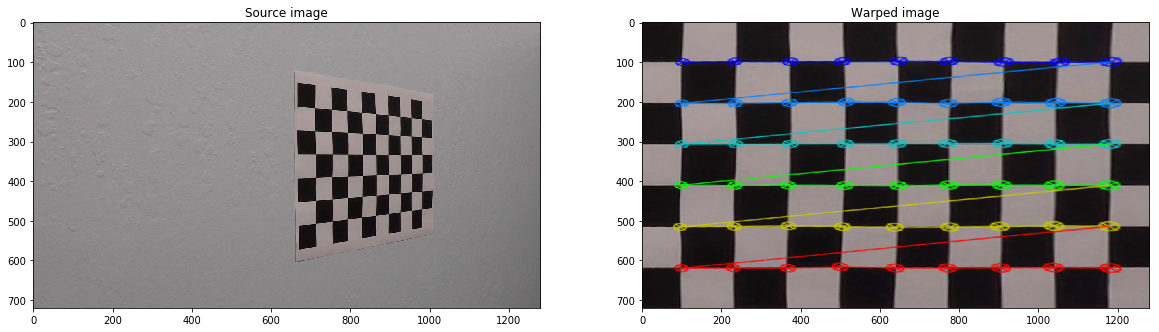

In [188]:
# Test the perspective transfom
img = cv2.imread('camera_cal/calibration8.jpg')
img_corrected = undistort(img, mtx, dist)
gray = cv2.cvtColor(img_corrected, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    cv2.drawChessboardCorners(img_corrected, (nx,ny), corners, ret)
    # src points
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    
    offset = 100 #offset for the dst points
    
    img_size = (img_corrected.shape[1], img_corrected.shape[0])
    
    # Define the dst points    
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                                     [img_size[0]-offset, img_size[1]-offset],
                                     [offset, img_size[1]-offset]])
    
    warped = warp(img_corrected, src, dst)

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.set_title('Source image')
    ax1.imshow(img)
    ax2.set_title('Warped image')
    ax2.imshow(warped)

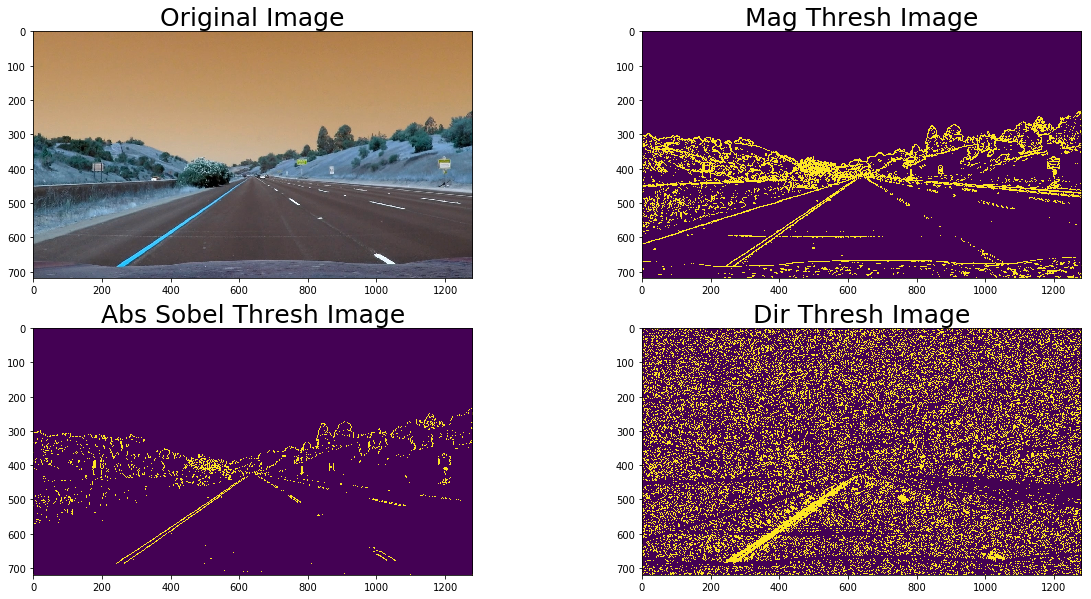

In [189]:
# Test the gradient threshold
image = cv2.imread('test_images/straight_lines1.jpg')

# The thresholds have been obtained by playing with them and observing the results in the test image, and
# ensuring that we detect correctly the lane lines with those thresholds

abs_sobel_thresh_img = abs_sobel_thresh(image, orient='x', thresh_min=30, thresh_max=150)
mag_thresh_img = mag_thresh(image, sobel_kernel = 3, mag_thresh=(20,150))

# For the directional threshold, we mainly want to detect close to vertical lines (0 degress: vertical lines)
dir_thresh_img = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.1)) #0.7 is aprox pi/4, and 1.1 is aprox pi/3

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(20,10))
axes[0,0].set_title('Original Image', fontsize=25)
axes[0,0].imshow(image)
axes[1,0].set_title('Abs Sobel Thresh Image', fontsize=25)
axes[1,0].imshow(abs_sobel_thresh_img)
axes[0,1].set_title('Mag Thresh Image', fontsize=25)
axes[0,1].imshow(mag_thresh_img)
axes[1,1].set_title('Dir Thresh Image', fontsize=25)
axes[1,1].imshow(dir_thresh_img)

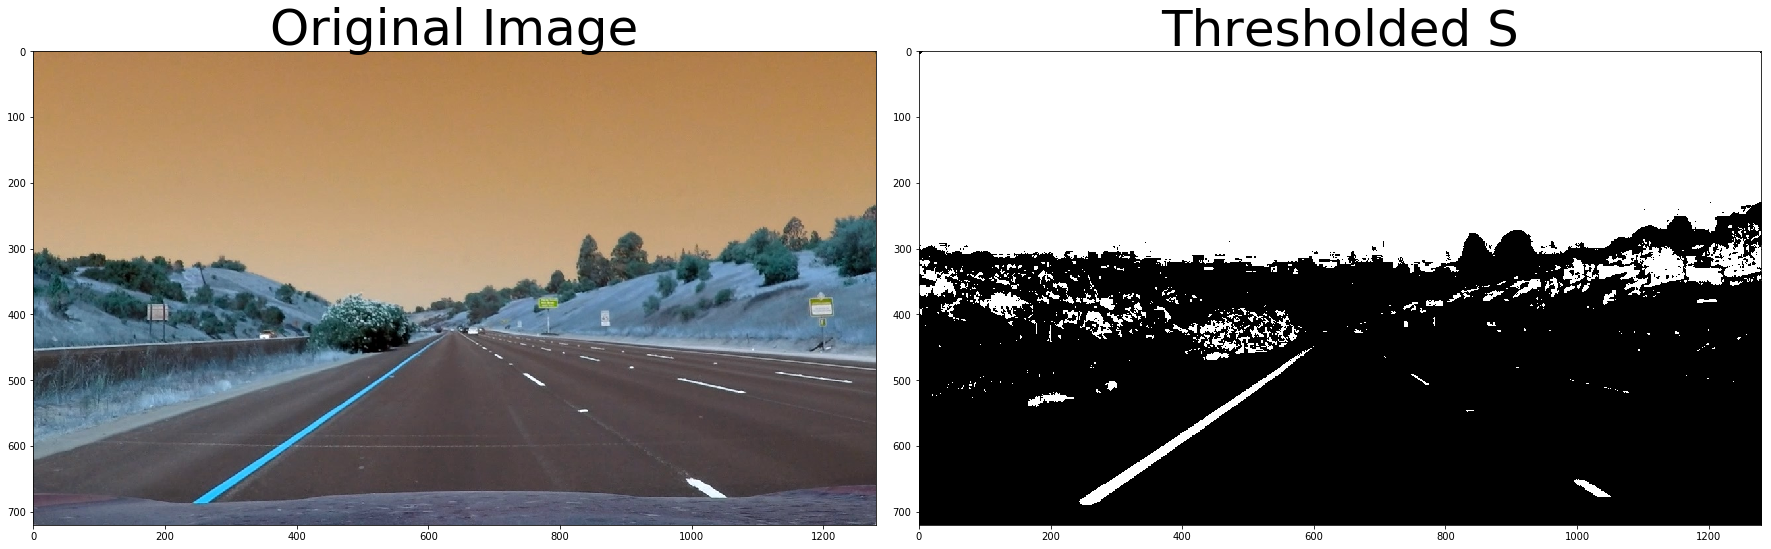

In [190]:
# Test the color filter
image = cv2.imread('test_images/straight_lines1.jpg')
hls_binary = hls_select(image, thresh=(90, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

We know have different functions in order to color filter (by using the HLS color space and filter through the S channel), and also by filtering through the gradient (applying sobel to 'x' and/or 'y' direction, directional gradient, magnitude gradient.

The following task is to determine what can work best in terms of which combination filtering to apply and also the tunning of the different parameters.

To achieve this, I read the different test image and apply the individual filters (Saturation filter, sobel in the x and y direction, magnitude of the gradient threshold and directional threshold). I try with different thresholding parameters and then decide which combination and tunning parameters could produce the best result. 

In [191]:
# The following code is to test the different filters, parameters and combinations of filters
testImages = glob.glob("test_images/test*.jpg")

for image in testImages:
    nameImage = image.split("/")[1]

    img = cv2.imread(image)

    abs_sobelx_thresh_img = abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=150) # these seems to detect the far end curve
    abs_sobely_thresh_img = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    mag_thresh_img = mag_thresh(img, sobel_kernel = 3, mag_thresh=(12,150)) # this seems the one that captures better the far curved line
    dir_thresh_img = dir_threshold(img, sobel_kernel=15, thresh=(0.8, 1.3)) 
    s_thresh = hls_select(img, thresh=(130, 255)) # these seems to detect better the closest lines

    mag_and_dir_img = np.zeros_like(dir_thresh_img)
    mag_and_dir_img[((mag_thresh_img == 1) & (dir_thresh_img == 1))] = 1
    
    combined_sobelx_or_sthresh = np.zeros_like(dir_thresh_img)
    combined_sobelx_or_sthresh[(abs_sobelx_thresh_img == 1) | (s_thresh == 1) ] = 1
    
    combined_mag_and_dir_or_sthresh = np.zeros_like(dir_thresh_img)
    combined_mag_and_dir_or_sthresh[(mag_and_dir_img == 1) | (s_thresh == 1) ] = 1

    cv2.imwrite('output_images/abel_sobelx_'+nameImage, abs_sobelx_thresh_img*255)
    cv2.imwrite('output_images/abel_sobely_'+nameImage, abs_sobely_thresh_img*255)
    cv2.imwrite('output_images/mag_thresh_'+nameImage, mag_thresh_img*255)
    cv2.imwrite('output_images/dir_thresh_'+nameImage, dir_thresh_img*255)
    cv2.imwrite('output_images/s_thresh_'+nameImage, s_thresh*255)
    cv2.imwrite('output_images/mag_and_dir_'+nameImage, mag_and_dir_img*255)
    cv2.imwrite('output_images/sobelx_or_sthresh_'+nameImage, combined_sobelx_or_sthresh*255)
    cv2.imwrite('output_images/mag_and_dir_or_sthresh_'+nameImage, combined_mag_and_dir_or_sthresh*255)


Observing the different images generated (see output_images/), the following conclusions were made:
* Magnitude threshold seems to be equivalent of the combination of sobelx and sobely together.
* Saturation filter seems to detect very well the lines that are close to camera.
* Gradient filtering seems to work well for lines that are far from the camera.
* Sobely does not seem to add much in line detection over sobelx.
* Sobelx does not seem as much noise as sobely.
* Magnitude gradient threshold seems to detect some far, small lines that are not detected with other filters. However, magnitude gradient threshold seems to add a bit of noise.

So, based on the observed results, I have tried two candidate combinations:
* sobelx or sthresh
* (magnitude of the gradient & direction of the gradient) or sthresh

The combination with the best results seems to be the first one (sobelx or sthresh).

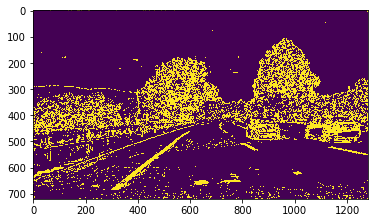

In [192]:
image = "test_images/test4.jpg" # an example of the test image
img = cv2.imread(image)
abs_sobelx_thresh_img = abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=150)
s_thresh = hls_select(img, thresh=(130, 255))

combined_img = np.zeros_like(dir_thresh_img)
combined_img[((abs_sobelx_thresh_img == 1) | (s_thresh == 1))] = 1
plt.imshow(combined_img)

For the perspective transform (to calculate the warped image), it is necessary to identify four source points. In our case, the four points should be four points in a trapezoidal shape, that would represent a rectangle when looking down on the road from above.

To achieve this, I take an image where the lane lines are stright, and find four points lying along the lines.

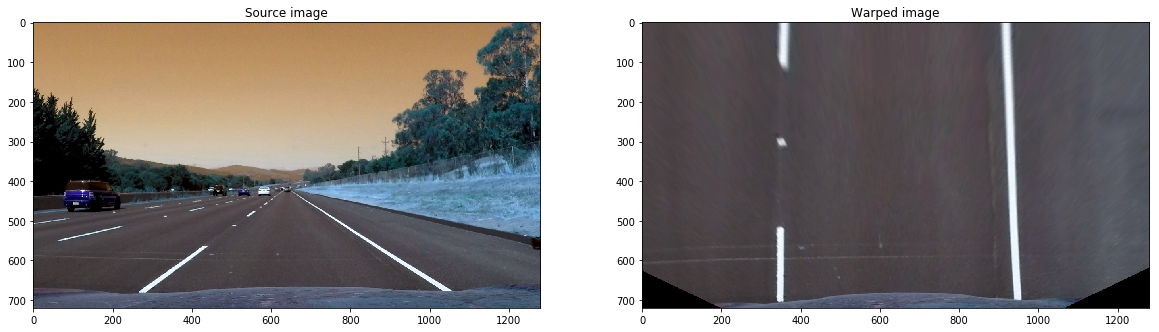

In [193]:
# Test the perspective transform in a road image

image = "test_images/straight_lines2.jpg" 
img = cv2.imread(image)
# The following coordinates are from a trapezoidal shape following the stright lines, and giving a bit of margin 
# in the x axis
#cv2.circle(img, (178,715), 10, [255,0,0], thickness=-1)
#cv2.circle(img, (576, 437), 10, [255,0,0], thickness=-1)
#cv2.circle(img, (699, 437), 10, [255,0,0], thickness=-1)
#cv2.circle(img, (1131, 716), 10, [255,0,0], thickness=-1)

#cv2.circle(img, (178, 720), 10, [255,0,0], thickness=-1)
#cv2.circle(img, (540, 460), 10, [255,0,0], thickness=-1)
#cv2.circle(img, (750, 460), 10, [255,0,0], thickness=-1)
#cv2.circle(img, (1127, 720), 10, [255,0,0], thickness=-1) 

# Test the perspective transfom of the road image using the warp_road, which as the hardcoded coordinates of the
# trapezoidal shape

img_corrected = undistort(img, mtx, dist)
warped = warp_road(img_corrected)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Warped image')
ax2.imshow(warped)

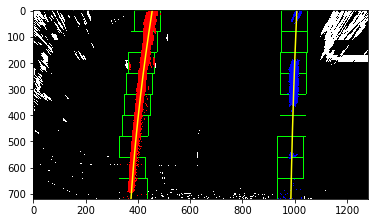

In [194]:
# Test the lane finding and polynomial fit

image = "test_images/test6.jpg" 
img = cv2.imread(image)

# Undistort the image (distortion correction)
img_corrected = undistort(img, mtx, dist)
# Create a binary image that contains a likely lane pixes (use color transforms, gradients).
abs_sobelx_thresh_img = abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=150)
s_thresh = hls_select(img, thresh=(130, 255))

binary_image = np.zeros_like(abs_sobelx_thresh_img)
binary_image[((abs_sobelx_thresh_img == 1) | (s_thresh == 1))] = 1
#binary_image[(s_thresh == 1)] = 1
# Perform a perspective transform: rectify the image to a "birds-eye view".
warped = warp_road(binary_image)
# Identify lane line pixels in the rectified binary images and fit the positions with a polynomial.
out_img = find_lines_and_fit_polynomial(warped)
plt.imshow(out_img)

Main problems in this process are found mainly on the discontinuous line, which is more affected by noise. Also, if at the bottom of the image there is no line, the first windows might not be positioned correctly as we do not have much information of the line at this point. I could minimize the problems by reducing the window width and also by increasing the minimum number of pixels activated in order to move the window. This helped minimize the impact of nosie data.

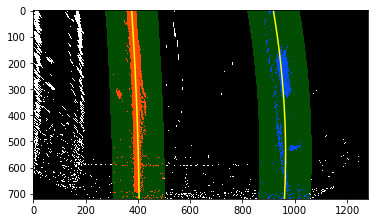

In [195]:
# Test the line finding using prior polynomial fit
image = "test_images/test2.jpg" 
img = cv2.imread(image)

# Undistort the image (distortion correction)
img_corrected = undistort(img, mtx, dist)
# Create a binary image that contains a likely lane pixes (use color transforms, gradients).
abs_sobelx_thresh_img = abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=150)
s_thresh = hls_select(img, thresh=(130, 255))

binary_image = np.zeros_like(abs_sobelx_thresh_img)
binary_image[((abs_sobelx_thresh_img == 1) | (s_thresh == 1))] = 1
# Perform a perspective transform: rectify the image to a "birds-eye view".
warped = warp_road(binary_image)

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

out_img =  search_around_poly(warped, left_fit, right_fit)
plt.imshow(out_img)

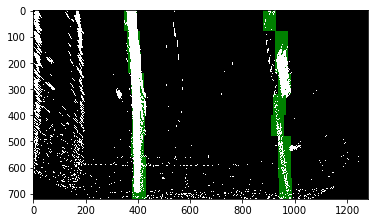

In [196]:
# Test line finding using convolution
image = "test_images/test2.jpg" 
img = cv2.imread(image)

# Undistort the image (distortion correction)
img_corrected = undistort(img, mtx, dist)
# Create a binary image that contains a likely lane pixes (use color transforms, gradients).
abs_sobelx_thresh_img = abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=150)
s_thresh = hls_select(img, thresh=(130, 255))

binary_image = np.zeros_like(abs_sobelx_thresh_img)
binary_image[((abs_sobelx_thresh_img == 1) | (s_thresh == 1))] = 1
# Perform a perspective transform: rectify the image to a "birds-eye view".
warped = warp_road(binary_image)
out_img = find_lines_convolution(warped)
plt.imshow(out_img)

In [197]:
# test calculate the curvature and the position of the vehicle
image = "test_images/test2.jpg" 
img = cv2.imread(image)

# Undistort the image (distortion correction)
img_corrected = undistort(img, mtx, dist)
# Create a binary image that contains a likely lane pixes (use color transforms, gradients).
abs_sobelx_thresh_img = abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=150)
s_thresh = hls_select(img, thresh=(130, 255))

binary_image = np.zeros_like(abs_sobelx_thresh_img)
binary_image[((abs_sobelx_thresh_img == 1) | (s_thresh == 1))] = 1
# Perform a perspective transform: rectify the image to a "birds-eye view".
warped = warp_road(binary_image)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

yeval = binary_image.shape[0]

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
left_fitx, right_fitx, ploty, left_fit_cr, right_fit_cr = fit_polynomial(img.shape, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix)
    
left_curverad, right_curverad = measure_curvature_world_space(yeval, left_fit_cr, right_fit_cr, ym_per_pix, xm_per_pix)

print("R left: " + str(left_curverad) + " m.")
print("R right: " + str(right_curverad) + " m.")
# vehicle position
vehicle_deviation = measure_vehicle_position(img.shape[0]*ym_per_pix, img.shape[1]*xm_per_pix, left_fit_cr, right_fit_cr)
print("Vehicle position: " + str(vehicle_deviation) + " m. ")

R left: 1518.03376228 m.
R right: 1413.91556612 m.
Vehicle position: 0.186857696977 m. 


Now the final step before trying with a video stream is to plot back onto the road the lane area, the lane lines from the polynomy calculated, the info of the curvature and vehicle position. 

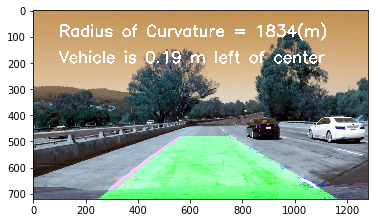

In [324]:
image = "test_images/test1.jpg" 
img = cv2.imread(image)

# Undistort the image (distortion correction)
img_corrected = undistort(img, mtx, dist)
# Create a binary image that contains a likely lane pixes (use color transforms, gradients).
abs_sobelx_thresh_img = abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=150)
s_thresh = hls_select(img, thresh=(130, 255))

binary_image = np.zeros_like(abs_sobelx_thresh_img)
binary_image[((abs_sobelx_thresh_img == 1) | (s_thresh == 1))] = 1
# Perform a perspective transform: rectify the image to a "birds-eye view".
warped = warp_road(binary_image)

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
left_fitx, right_fitx, ploty, left_fit_cr, right_fit_cr = fit_polynomial(img.shape, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix)
yeval = binary_image.shape[0]
left_curverad, right_curverad = measure_curvature_world_space(yeval, left_fit_cr, right_fit_cr, ym_per_pix, xm_per_pix)
vehicle_deviation = measure_vehicle_position(img.shape[0]*ym_per_pix, img.shape[1]*xm_per_pix, left_fit_cr, right_fit_cr)

left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(img.shape, leftx, lefty, rightx, righty)

R = left_curverad

result = drawing_info_original_image(img, warped, left_fitx, right_fitx, leftx, rightx, lefty, righty, ploty, R, vehicle_deviation)

plt.imshow(result)

## Pipeline (video)

Run the above pipeline in a video. Lines, curvature and vehicle position are identified at every frame. Usse information from prior detection to inform the search for the position of the lines in subsequent frames of the video.

Smoothing for lane detection (low pass filter?). Add each new detection to a weighted mean of the position of the liens to avoid jitter.

In [270]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

In [325]:
#Xmax_right_history = deque(maxlen=10)

def process_image(image):
    imageOriginal = np.copy(image)
    
    # undistort the image using the camera calibration
    img_corrected = undistort(imageOriginal, mtx, dist)
    
    # apply thresholds to create a binary image 
    abs_sobelx_thresh_img = abs_sobel_thresh(img_corrected, orient='x', thresh_min=10, thresh_max=150)
    s_thresh = hls_select(img_corrected, thresh=(130, 255))

    binary_image = np.zeros_like(abs_sobelx_thresh_img)
    binary_image[((abs_sobelx_thresh_img == 1) | (s_thresh == 1))] = 1

    # apply a perspective transform
    warped = warp_road(binary_image)

    # lane finding
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

    # fit polynomial and prepare image to display
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fitx, right_fitx, ploty, left_fit_cr, right_fit_cr = fit_polynomial(binary_image.shape, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix)
    yeval = binary_image.shape[0]
    left_curverad, right_curverad = measure_curvature_world_space(yeval, left_fit_cr, right_fit_cr, ym_per_pix, xm_per_pix)
    vehicle_deviation = measure_vehicle_position(binary_image.shape[0]*ym_per_pix, binary_image.shape[1]*xm_per_pix, left_fit_cr, right_fit_cr)

    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(binary_image.shape, leftx, lefty, rightx, righty)

    R = left_curverad

    result = drawing_info_original_image(imageOriginal, warped, left_fitx, right_fitx, leftx, rightx, lefty, righty, ploty, R, vehicle_deviation)
    #result = drawing_info_original_image(imageOriginal, warped, left_fitx, right_fitx, ploty, 0,0)
    return result

In [327]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [02:26<00:00, 10.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 3min 20s, sys: 41.3 s, total: 4min 2s
Wall time: 2min 27s


In [318]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Discussion

Discuss problems, issues during implementation. When the pipeline might fail. What can be done to make it more robust.

For the single image processing:

- The gradient filter can introduce quite a bit of noise, which influences significantly, specially, on the lines that are discontinuous.
- Initial positioning of the line, might not have pixel information for the discontinous lines, so this can make the polynomial interpolation to be wrong.
- Radious of the curvature seems to be a bit noisy